<a href="https://colab.research.google.com/github/Antonyevan/FINAL-PROJECT/blob/main/Gaussian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import os
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.gaussian_process import GaussianProcessRegressor
from scipy.interpolate import interp1d

In [ ]:
# Load the metadata CSV file
metadata_file_path = '/content/drive/MyDrive/CSPII_NIR_Ia_spectra/Lu2023_TableA1_extension.csv'
metadata_df = pd.read_csv(metadata_file_path)

# Directory containing the FITS files
fits_data_directory = '/content/drive/MyDrive/CSPII_NIR_Ia_spectra/observed_spectra/spec_fits'


In [ ]:
# Function to process FITS file
def process_fits_file(file_path):
    with fits.open(file_path) as hdul:
        wv, fx, fx_err = hdul[0].data
    reasonable_indices = (wv >= 0.7) & (wv <= 2.5)
    wv = wv[reasonable_indices]
    fx = fx[reasonable_indices]
    fx_err = fx_err[reasonable_indices]
    return wv, fx, fx_err

def pEW(wavelength, flux, cont_coords):
    from scipy.interpolate import interp1d
    cont = interp1d(cont_coords[0], cont_coords[1], bounds_error=False, fill_value=1)
    nflux = flux / cont(wavelength)
    pEW = 0
    for i in range(len(wavelength)):
        if wavelength[i] > cont_coords[0, 0] and wavelength[i] < cont_coords[0, 1]:
            dwave = 0.5 * (wavelength[i + 1] - wavelength[i - 1])
            pEW += dwave * (1 - nflux[i])
    return pEW

def compute_pew_for_Ca_II_IR(wv, fx, zhel):
    # Define the wavelength ranges for the Ca II IR feature
    rest_wavelength = wv / (1 + zhel)
    line_data = ('Ca II IR', 0.8150, 0.7800, 0.8000, 0.8500, 0.8800)
    element, rest_wavelength_center, low_1, high_1, low_2, high_2 = line_data

    # Find indices corresponding to the wavelength ranges
    range1 = (rest_wavelength >= low_1) & (rest_wavelength <= high_1)
    range2 = (rest_wavelength >= low_2) & (rest_wavelength <= high_2)

    # Select the wavelengths and fluxes in the specified ranges
    wv_range1 = rest_wavelength[range1]
    fx_range1 = fx[range1]
    wv_range2 = rest_wavelength[range2]
    fx_range2 = fx[range2]

    # Calculate the continuum coordinates
    cont_coords = np.array([[low_1, low_2], [np.mean(fx_range1), np.mean(fx_range2)]])

    # Compute pEW
    pew_value = pEW(rest_wavelength, fx, cont_coords)

    return pew_value

def plot_spectrum(wv, flux, flux_err, title):
            plt.figure(figsize=(12, 6))
            plt.plot(wv, flux, label='Flux')
            plt.fill_between(wv, flux - flux_err, flux + flux_err, color='gray', alpha=0.3, label='Flux Error')
            plt.xlabel('Wavelength (μm)')
            plt.ylabel('Flux')
            plt.title(title)
            plt.legend()
            plt.show()

# Function to extract features from the spectrum
def extract_features(wv, fx):
    features = {}
    features['mean_flux'] = np.mean(fx)
    features['median_flux'] = np.median(fx)
    features['std_flux'] = np.std(fx)
    features['max_flux'] = np.max(fx)
    features['min_flux'] = np.min(fx)
    features['wavelength_at_max_flux'] = wv[np.argmax(fx)]
    features['wavelength_at_min_flux'] = wv[np.argmin(fx)]

     # Calculation of flux in specific bands (Y: 1.0-1.1 µm, J: 1.1-1.4 µm, H: 1.5-1.8 µm, K: 2.0-2.5 µm)
    features['flux I'] = np.mean(fx[(wv >= 0.7) & (wv <= 0.9)])
    features['flux_Y'] = np.mean(fx[(wv >= 1.0) & (wv <= 1.1)])
    features['flux_J'] = np.mean(fx[(wv >= 1.1) & (wv <= 1.4)])
    features['flux_H'] = np.mean(fx[(wv >= 1.5) & (wv <= 1.8)])
    features['flux_K'] = np.mean(fx[(wv >= 2.0) & (wv <= 2.5)])

    return features

# Initialize an empty list to store features
features_list = []

# Process each file listed in the metadata
for index, row in metadata_df.iterrows():
    filename = row['filename']
    file_path_fits = os.path.join(fits_data_directory, f'{filename}.fits')
    zhel = row['zhel']
    Tmax = row['Tmax(MJD)']
    sBV = row['sBV']

    try:
        if os.path.exists(file_path_fits):
            wv, fx, fx_err = process_fits_file(file_path_fits)
            rest_wavelength = wv/ (1+zhel)

            '''if wv is not None:

                features['filename'] = filename
                features['zhel'] = zhel
                features['Tmax(MJD)'] = Tmax
                features['sBV'] = sBV
                features = extract_features(rest_wavelength, fx)
                features_list.append(features)
        else:
            continue'''

            if wv is not None:
                pew_value = compute_pew_for_Ca_II_IR(wv, fx, zhel)
                print(f'Pseudo-equivalent width for Ca II IR in {filename}: {pew_value:.2f} Å')
                # Plot the spectrum and highlight the pEW calculation regions
                plot_spectrum(rest_wavelength, fx, fx_err, 'Spectrum of ' + filename)
                additional_features = extract_features(rest_wavelength, fx)

                # Create a dictionary for the features of this file
                features = {
                    'filename': filename,
                    'zhel': zhel,
                    'Tmax(MJD)': Tmax,
                    'sBV': sBV,
                    'pew': pew_value
                }


                features.update(additional_features)
                # Append the features dictionary to the features_list
                features_list.append(features)

        else:
            continue



    except Exception as e:
        print(f"Error processing file {filename}: {e}")
        continue


features_df = pd.DataFrame(features_list)

features_df.to_csv('extracted_features.csv', index=False)


features_df.head()


In [ ]:
# Function to process FITS file
def process_fits_file(file_path):
    with fits.open(file_path) as hdul:
        wv, fx, fx_err = hdul[0].data
    reasonable_indices = (wv >= 0.7) & (wv <= 2.5)
    wv = wv[reasonable_indices]
    fx = fx[reasonable_indices]
    fx_err = fx_err[reasonable_indices]
    return wv, fx, fx_err

def pEW(wavelength, flux, cont_coords):
    # Interpolate the continuum
    cont = interp1d(cont_coords[0], cont_coords[1], bounds_error=False, fill_value=1)
    # Normalize the flux by the continuum
    nflux = flux / cont(wavelength)
    pEW = 0
    # Loop through the wavelengths, avoiding the boundaries
    for i in range(1, len(wavelength)-1):
        if cont_coords[0, 0] < wavelength[i] < cont_coords[0, 1]:
            dwave = 0.5 * (wavelength[i + 1] - wavelength[i - 1])
            pEW += dwave * (1 - nflux[i])
    return pEW

def compute_pew_for_Ca_II_IR(wv, fx, zhel):
    # Define the rest wavelength for the Ca II IR feature
    rest_wavelength = wv / (1 + zhel)
    line_data = ('Ca II IR', 0.8150, 0.7800, 0.8000, 0.8500, 0.8800)
    element, rest_wavelength_center, low_1, high_1, low_2, high_2 = line_data

    # Find indices corresponding to the wavelength ranges
    range1 = (rest_wavelength >= low_1) & (rest_wavelength <= high_1)
    range2 = (rest_wavelength >= low_2) & (rest_wavelength <= high_2)

    # Select the wavelengths and fluxes in the specified ranges
    wv_range1 = rest_wavelength[range1]
    fx_range1 = fx[range1]
    wv_range2 = rest_wavelength[range2]
    fx_range2 = fx[range2]

    # Calculate the continuum coordinates
    cont_coords = np.array([[low_1, low_2], [np.mean(fx_range1), np.mean(fx_range2)]])

    # Compute pEW
    pew_value = pEW(rest_wavelength, fx, cont_coords)

    return pew_value

def plot_spectrum(wv, flux, flux_err, title):
            plt.figure(figsize=(12, 6))
            plt.plot(wv, flux, label='Flux')
            plt.fill_between(wv, flux - flux_err, flux + flux_err, color='gray', alpha=0.3, label='Flux Error')
            plt.xlabel('Wavelength (μm)')
            plt.ylabel('Flux')
            plt.title(title)
            plt.legend()
            plt.show()

# Function to extract features from the spectrum
def extract_features(wv, fx):
    features = {}
    features['mean_flux'] = np.mean(fx)
    features['median_flux'] = np.median(fx)
    features['std_flux'] = np.std(fx)
    features['max_flux'] = np.max(fx)
    features['min_flux'] = np.min(fx)
    features['wavelength_at_max_flux'] = wv[np.argmax(fx)]
    features['wavelength_at_min_flux'] = wv[np.argmin(fx)]

     # Calculation of flux in specific bands (Y: 1.0-1.1 µm, J: 1.1-1.4 µm, H: 1.5-1.8 µm, K: 2.0-2.5 µm)
    features['flux I'] = np.mean(fx[(wv >= 0.7) & (wv <= 0.9)])
    features['flux_Y'] = np.mean(fx[(wv >= 1.0) & (wv <= 1.1)])
    features['flux_J'] = np.mean(fx[(wv >= 1.1) & (wv <= 1.4)])
    features['flux_H'] = np.mean(fx[(wv >= 1.5) & (wv <= 1.8)])
    features['flux_K'] = np.mean(fx[(wv >= 2.0) & (wv <= 2.5)])

    return features

# Initialize an empty list to store features
features_list = []

# Process each file listed in the metadata
for index, row in metadata_df.iterrows():
    filename = row['filename']
    file_path_fits = os.path.join(fits_data_directory, f'{filename}.fits')
    zhel = row['zhel']
    Tmax = row['Tmax(MJD)']
    sBV = row['sBV']

    try:
        if os.path.exists(file_path_fits):
            wv, fx, fx_err = process_fits_file(file_path_fits)
            rest_wavelength = wv/ (1+zhel)

            '''if wv is not None:

                features['filename'] = filename
                features['zhel'] = zhel
                features['Tmax(MJD)'] = Tmax
                features['sBV'] = sBV
                features = extract_features(rest_wavelength, fx)
                features_list.append(features)
        else:
            continue'''

            if wv is not None:
                pew_value = compute_pew_for_Ca_II_IR(wv, fx, zhel)
                print(f'Pseudo-equivalent width for Ca II IR in {filename}: {pew_value:.2f} Å')
                # Plot the spectrum and highlight the pEW calculation regions
                plot_spectrum(rest_wavelength, fx, fx_err, 'Spectrum of ' + filename)
                additional_features = extract_features(rest_wavelength, fx)

                # Create a dictionary for the features of this file
                features = {
                    'filename': filename,
                    'zhel': zhel,
                    'Tmax(MJD)': Tmax,
                    'sBV': sBV,
                    'pew': pew_value
                }


                features.update(additional_features)
                # Append the features dictionary to the features_list
                features_list.append(features)

        else:
            continue



    except Exception as e:
        print(f"Error processing file {filename}: {e}")
        continue


features_df = pd.DataFrame(features_list)

features_df.to_csv('extracted_features.csv', index=False)


features_df.head()


In [ ]:

def process_fits_file(file_path):
    with fits.open(file_path) as hdul:
        wv, fx, fx_err = hdul[0].data
    reasonable_indices = (wv >= 0.7) & (wv <= 2.5)
    wv = wv[reasonable_indices]
    fx = fx[reasonable_indices]
    fx_err = fx_err[reasonable_indices]
    return wv, fx, fx_err

def pEW(wavelength, flux, cont_coords):
    # Interpolate the continuum
    cont = interp1d(cont_coords[0], cont_coords[1], bounds_error=False, fill_value=1)
    # Normalize the flux by the continuum
    nflux = flux / cont(wavelength)
    pEW = 0
    # Loop through the wavelengths, avoiding the boundaries
    for i in range(1, len(wavelength)-1):
        if cont_coords[0, 0] < wavelength[i] < cont_coords[0, 1]:
            dwave = 0.5 * (wavelength[i + 1] - wavelength[i - 1])
            pEW += dwave * (1 - nflux[i])
    return pEW

def compute_pew_for_Ca_II_IR(wv, fx, zhel):
    # Define the rest wavelength for the Ca II IR feature
    rest_wavelength = wv / (1 + zhel)
    line_data = ('Ca II IR', 0.8150, 0.7800, 0.8000, 0.8500, 0.8800)
    element, rest_wavelength_center, low_1, high_1, low_2, high_2 = line_data

    # Find indices corresponding to the wavelength ranges
    range1 = (rest_wavelength >= low_1) & (rest_wavelength <= high_1)
    range2 = (rest_wavelength >= low_2) & (rest_wavelength <= high_2)

    # Select the wavelengths and fluxes in the specified ranges
    wv_range1 = rest_wavelength[range1]
    fx_range1 = fx[range1]
    wv_range2 = rest_wavelength[range2]
    fx_range2 = fx[range2]

    # Calculate the continuum coordinates
    cont_coords = np.array([[low_1, low_2], [np.mean(fx_range1), np.mean(fx_range2)]])

    # Compute pEW
    pew_value = pEW(rest_wavelength, fx, cont_coords)

    # Calculate the centroid of the absorption feature for velocity shift calculation
    # Use both ranges to get a better estimate of the centroid
    all_wv_range = np.concatenate([wv_range1, wv_range2])
    all_fx_range = np.concatenate([fx_range1, fx_range2])

    # Weighted centroid calculation
    centroid_wavelength = np.sum(all_wv_range * all_fx_range) / np.sum(all_fx_range)

    # Calculate the velocity shift (in km/s)
    delta_wavelength = centroid_wavelength - rest_wavelength_center
    velocity = (delta_wavelength / rest_wavelength_center) * 3e5  # speed of light in km/s

    return pew_value, velocity

def plot_spectrum(wv, flux, flux_err, title):
    plt.figure(figsize=(12, 6))
    plt.plot(wv, flux, label='Flux')
    plt.fill_between(wv, flux - flux_err, flux + flux_err, color='gray', alpha=0.3, label='Flux Error')
    plt.xlabel('Wavelength (μm)')
    plt.ylabel('Flux')
    plt.title(title)
    plt.legend()
    plt.show()

def extract_features(wv, fx):
    features = {}
    features['mean_flux'] = np.mean(fx)
    features['median_flux'] = np.median(fx)
    features['std_flux'] = np.std(fx)
    features['max_flux'] = np.max(fx)
    features['min_flux'] = np.min(fx)
    features['wavelength_at_max_flux'] = wv[np.argmax(fx)]
    features['wavelength_at_min_flux'] = wv[np.argmin(fx)]

    # Calculation of flux in specific bands (Y: 1.0-1.1 µm, J: 1.1-1.4 µm, H: 1.5-1.8 µm, K: 2.0-2.5 µm)
    features['flux I'] = np.mean(fx[(wv >= 0.7) & (wv <= 0.9)])
    features['flux_Y'] = np.mean(fx[(wv >= 1.0) & (wv <= 1.1)])
    features['flux_J'] = np.mean(fx[(wv >= 1.1) & (wv <= 1.4)])
    features['flux_H'] = np.mean(fx[(wv >= 1.5) & (wv <= 1.8)])
    features['flux_K'] = np.mean(fx[(wv >= 2.0) & (wv <= 2.5)])

    return features

# Initialize an empty list to store features
features_list = []

# Process each file listed in the metadata
for index, row in metadata_df.iterrows():
    filename = row['filename']
    file_path_fits = os.path.join(fits_data_directory, f'{filename}.fits')
    zhel = row['zhel']
    Tmax = row['Tmax(MJD)']
    sBV = row['sBV']

    try:
        if os.path.exists(file_path_fits):
            wv, fx, fx_err = process_fits_file(file_path_fits)
            rest_wavelength = wv / (1 + zhel)

            if wv is not None:
                pew_value, velocity = compute_pew_for_Ca_II_IR(wv, fx, zhel)
                print(f'Pseudo-equivalent width for Ca II IR in {filename}: {pew_value:.2f} Å')
                print(f'Velocity shift for Ca II IR in {filename}: {velocity:.2f} km/s')

                # Plot the spectrum and highlight the pEW calculation regions
                plot_spectrum(rest_wavelength, fx, fx_err, 'Spectrum of ' + filename)
                additional_features = extract_features(rest_wavelength, fx)

                # Create a dictionary for the features of this file
                features = {
                    'filename': filename,
                    'zhel': zhel,
                    'Tmax(MJD)': Tmax,
                    'sBV': sBV,
                    'pew': pew_value,
                    'velocity': velocity
                }

                features.update(additional_features)
                # Append the features dictionary to the features_list
                features_list.append(features)

        else:
            continue

    except Exception as e:
        print(f"Error processing file {filename}: {e}")
        continue

features_df = pd.DataFrame(features_list)
features_df.to_csv('extracted_features.csv', index=False)
features_df.head()


In [ ]:

print("Initial missing values:\n", features_df.isnull().sum())


features_df_cleaned = features_df.dropna()

print("Missing values after removing rows:\n", features_df_cleaned.isnull().sum())


features_df_cleaned.to_csv('extracted_features_cleaned.csv', index=False)


print(features_df_cleaned.head())


Initial missing values:
 filename                  0
zhel                      0
Tmax(MJD)                 0
sBV                       0
pew                       7
velocity                  0
mean_flux                 2
median_flux               2
std_flux                  2
max_flux                  2
min_flux                  2
wavelength_at_max_flux    0
wavelength_at_min_flux    0
flux I                    0
flux_Y                    0
flux_J                    0
flux_H                    0
flux_K                    2
dtype: int64
Missing values after removing rows:
 filename                  0
zhel                      0
Tmax(MJD)                 0
sBV                       0
pew                       0
velocity                  0
mean_flux                 0
median_flux               0
std_flux                  0
max_flux                  0
min_flux                  0
wavelength_at_max_flux    0
wavelength_at_min_flux    0
flux I                    0
flux_Y                    0
f

In [ ]:
features_df_cleaned['pew']

0      0.018486
1      0.028867
2      0.053259
3     -0.791108
4     -0.786107
         ...   
334    7.197356
335   -2.643917
336    4.244775
337   -0.830471
338   -1.516392
Name: pew, Length: 331, dtype: float64

In [ ]:
import pandas as pd
import numpy as np


# Min-Max normalization
def min_max_normalize(series):
    min_val = series.min()
    max_val = series.max()
    return (series - min_val) / (max_val - min_val)

# Apply normalization to the 'pew' column
features_df_cleaned['pew_normalized'] = min_max_normalize(features_df_cleaned['pew'])

# Display the DataFrame with normalized values
print(features_df_cleaned)


                    filename    zhel  Tmax(MJD)    sBV       pew  \
0     ASAS14ad_20140208_fire  0.0264   56692.70  1.013  0.018486   
1     ASAS14ad_20140215_fire  0.0264   56692.70  1.013  0.028867   
2     ASAS14ad_20140222_fire  0.0264   56692.70  1.013  0.053259   
3     ASAS14ad_20140227_fire  0.0264   56692.70  1.013  0.035828   
4     ASAS14ad_20140310_fire  0.0264   56692.70  1.013  0.040184   
..                       ...     ...        ...    ...       ...   
334   CSP15aae_20150307_fire  0.0162   57076.02  0.505  0.034488   
335  SNhunt281_20150402_fire  0.0041   57112.67  0.692 -1.799451   
336  SNhunt281_20150407_fire  0.0041   57112.67  0.692 -0.011863   
337  SNhunt281_20150412_fire  0.0041   57112.67  0.692  0.013651   
338  SNhunt281_20150601_fire  0.0041   57112.67  0.692  0.043354   

         velocity     mean_flux   median_flux      std_flux      max_flux  \
0     8727.325837  4.216527e-16  2.181891e-16  4.569898e-16  3.187331e-15   
1    10057.811210  3.772785e-

<ipython-input-6-f8a639e5bd6e>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df_cleaned['pew_normalized'] = min_max_normalize(features_df_cleaned['pew'])


<ipython-input-7-cf996f9f69ab>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_copy['magI'] = -2.5 * np.log10(features_copy['flux I'] / 1.0e-10)


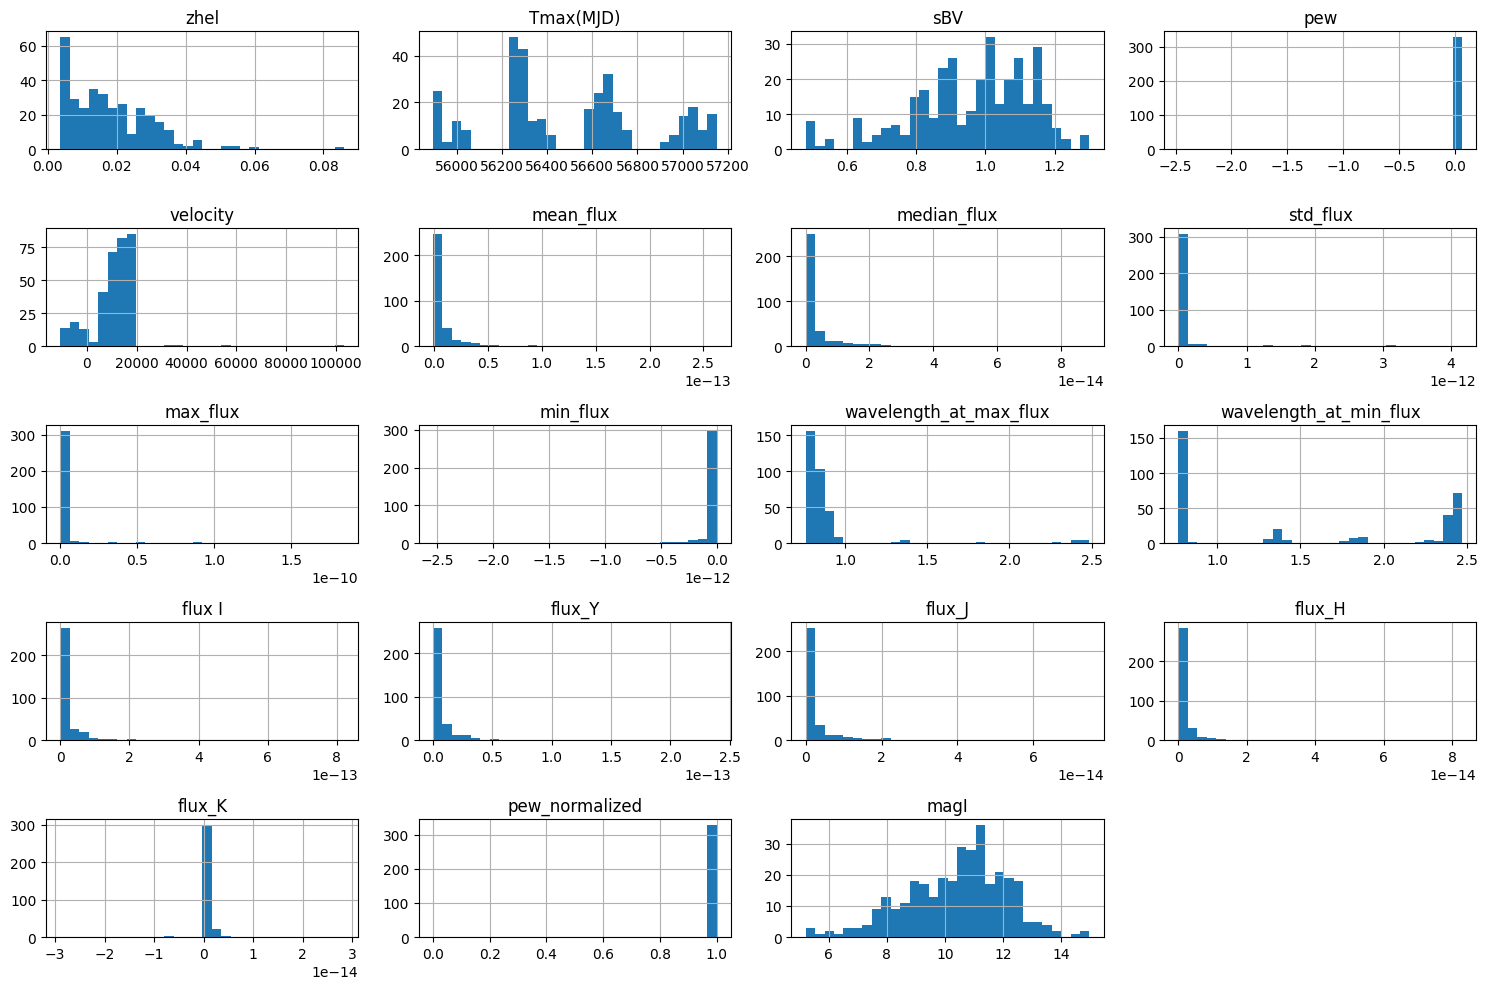

In [ ]:

features_copy = features_df_cleaned
features_copy['magI'] = -2.5 * np.log10(features_copy['flux I'] / 1.0e-10)
import matplotlib.pyplot as plt

features_to_plot = [col for col in features_copy.columns if col not in ['filename']]


features_copy[features_to_plot].hist(bins=30, figsize=(15, 10))
plt.tight_layout()
plt.show()


ValueError: num must be an integer with 1 <= num <= 16, not 17

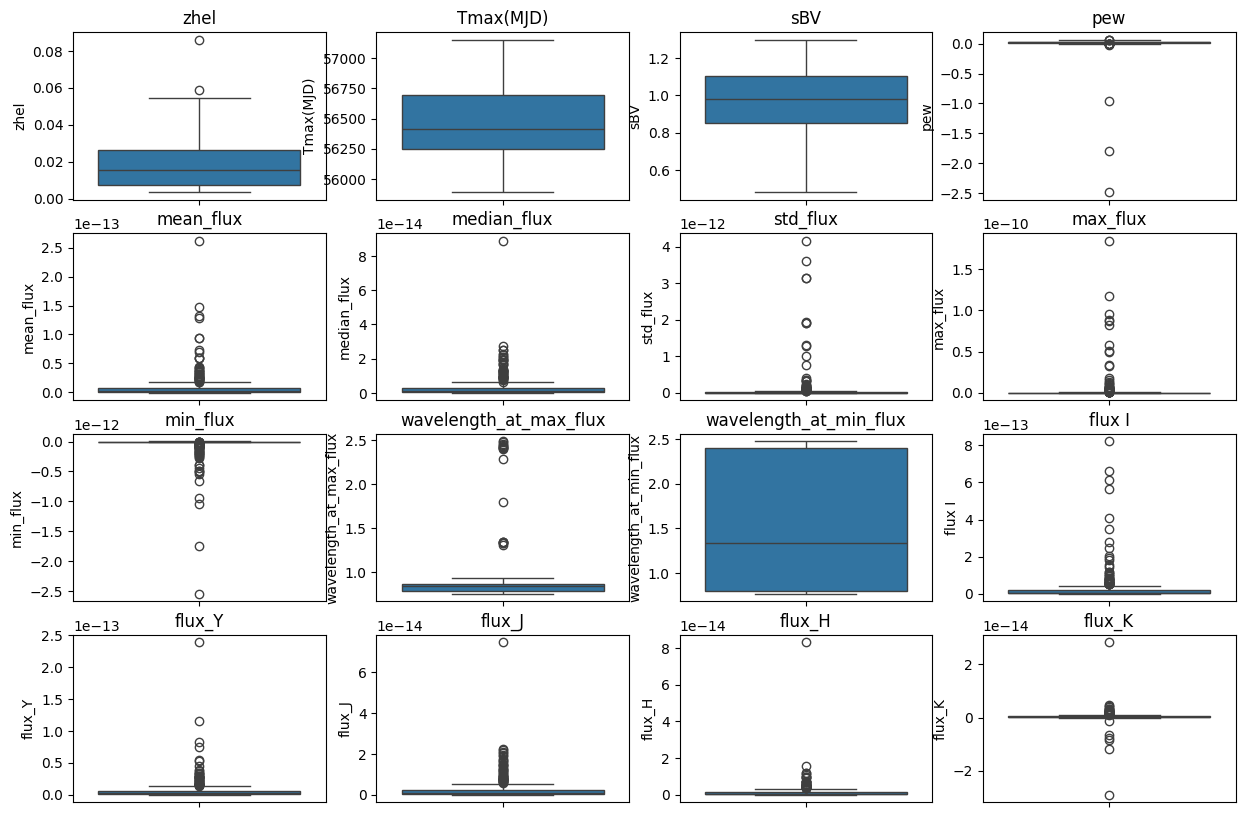

In [ ]:
import seaborn as sns


plt.figure(figsize=(15, 10))
for i, column in enumerate(features_to_plot):
    plt.subplot(4, 4, i + 1)
    sns.boxplot(y=features_copy[column])
    plt.title(column)
plt.tight_layout()
plt.show()


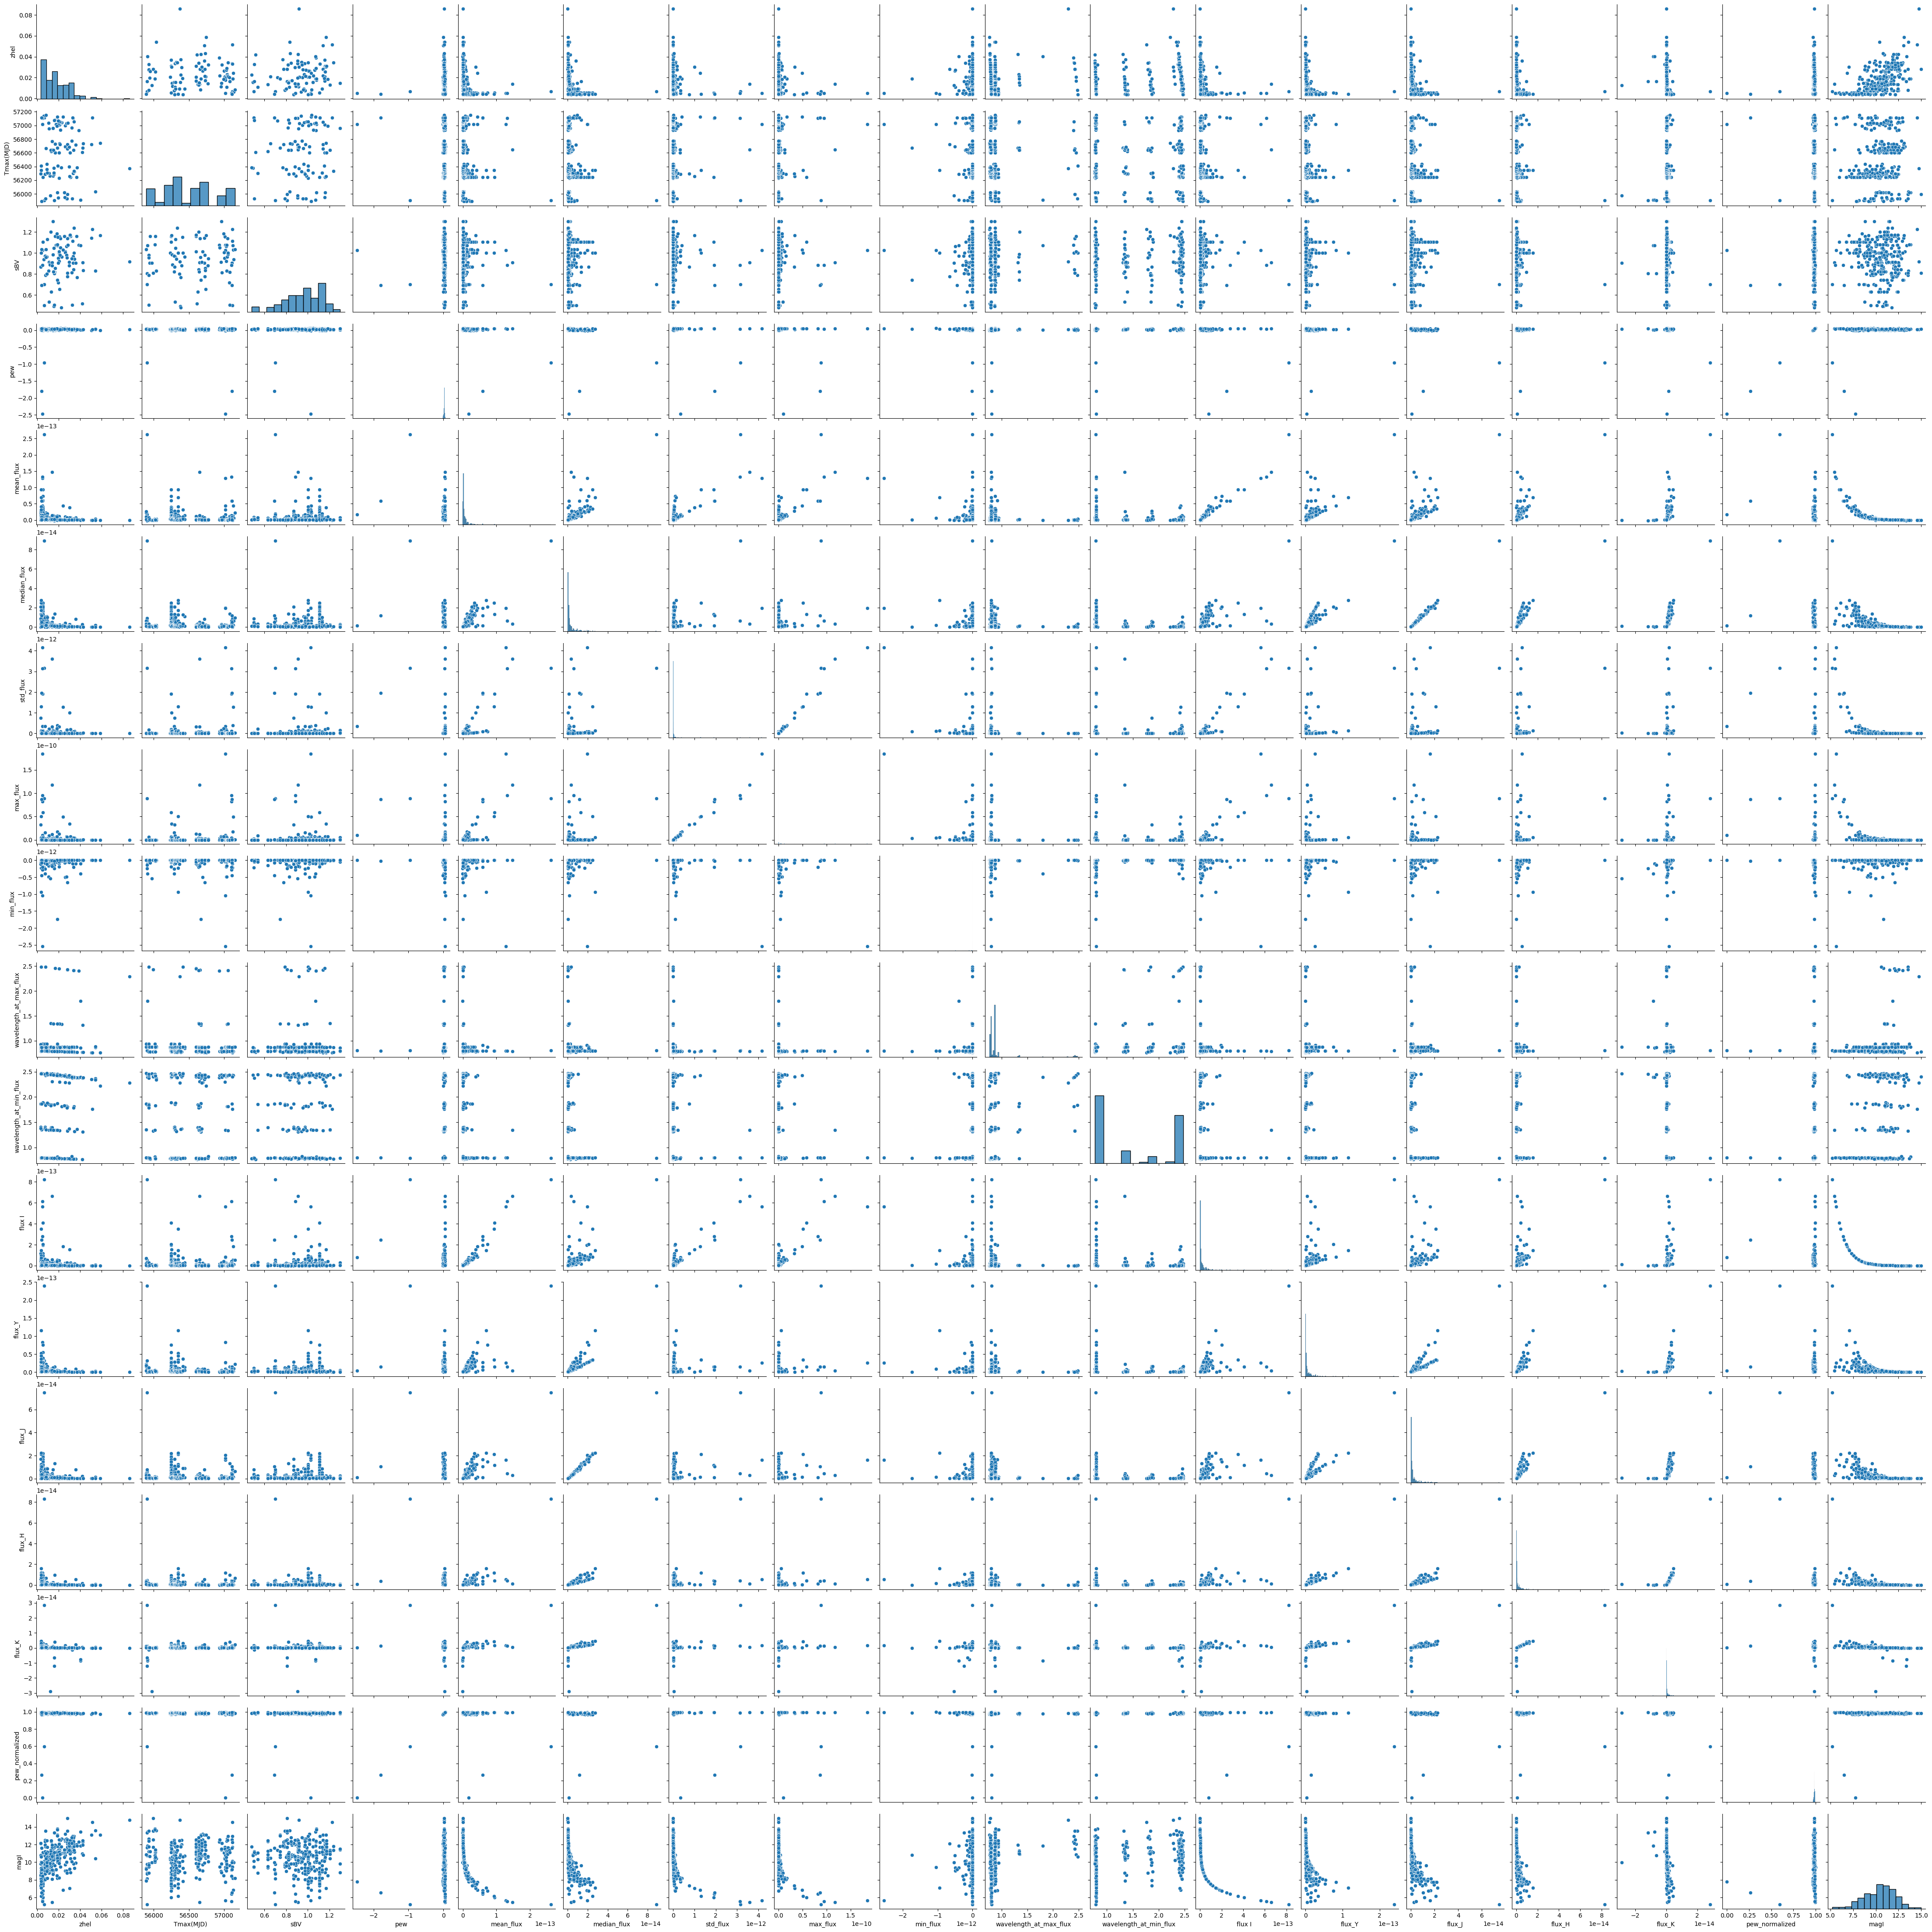

In [ ]:

sns.pairplot(features_copy[features_to_plot])
plt.show()


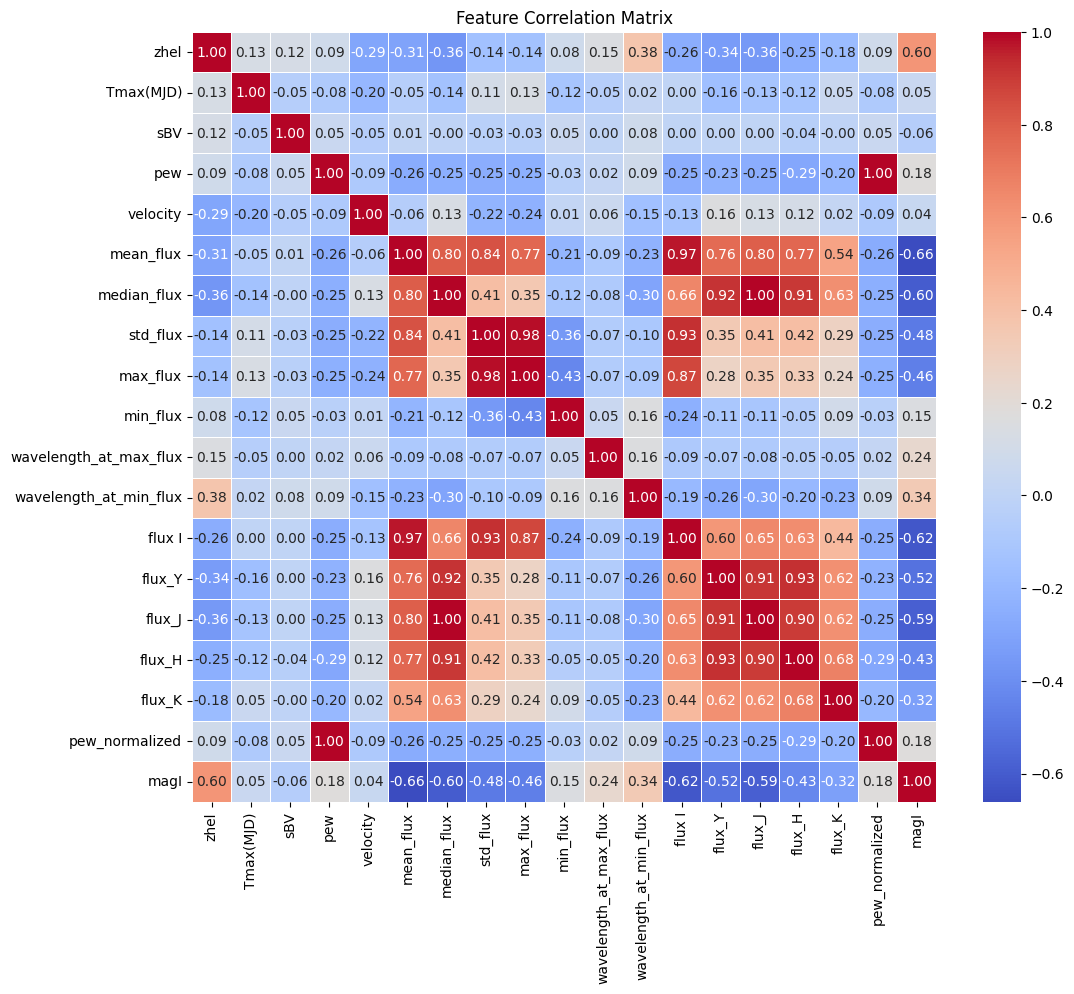

In [ ]:

correlation_matrix = features_copy[features_to_plot].corr()


plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.show()


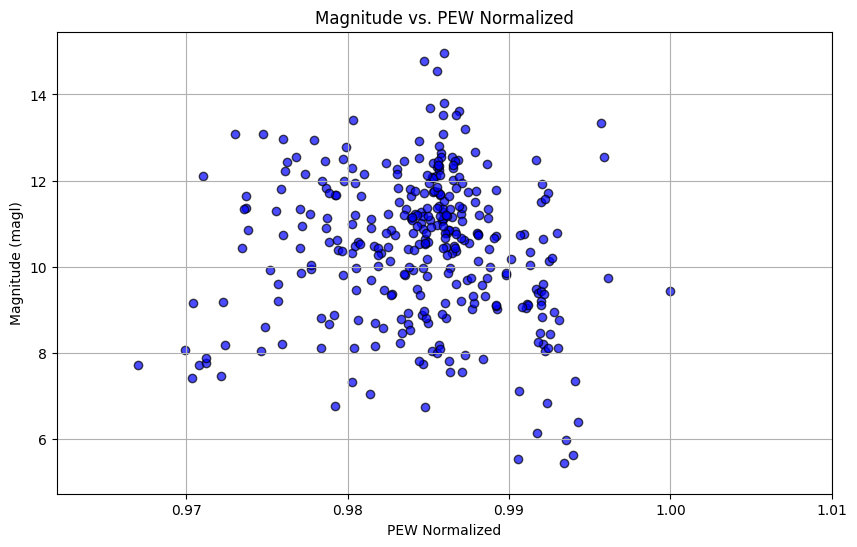

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(features_copy['pew_normalized'], features_copy['magI'], color='blue', alpha=0.7, edgecolors='k')
plt.xlim(0.962, 1.01)  # Set the x-axis range
plt.xlabel('PEW Normalized')
plt.ylabel('Magnitude (magl)')
plt.title('Magnitude vs. PEW Normalized')
plt.grid(True)
plt.show()

In [ ]:
# Filter the DataFrame for pew values between 0.962 and 1.01
filtered_pew = features_copy[(features_copy['pew_normalized'] > 0.962) & (features_copy['pew_normalized'] < 1.01)]

# Count the number of rows that match the filter
count = filtered_pew.shape[0]

print(f"Number of pEW values between 0.962 and 1.01: {count}")


Number of pEW values between 0.962 and 1.01: 328


In [ ]:
filtered_pew_df = features_copy[(features_copy['pew_normalized'] > 0.962) & (features_copy['pew_normalized'] < 1.01)]

# Print the new DataFrame
print(filtered_pew_df)


                    filename    zhel  Tmax(MJD)    sBV       pew  \
0     ASAS14ad_20140208_fire  0.0264   56692.70  1.013  0.018486   
1     ASAS14ad_20140215_fire  0.0264   56692.70  1.013  0.028867   
2     ASAS14ad_20140222_fire  0.0264   56692.70  1.013  0.053259   
3     ASAS14ad_20140227_fire  0.0264   56692.70  1.013  0.035828   
4     ASAS14ad_20140310_fire  0.0264   56692.70  1.013  0.040184   
..                       ...     ...        ...    ...       ...   
333    SN2015F_20150602_fire  0.0049   57106.85  0.884  0.048589   
334   CSP15aae_20150307_fire  0.0162   57076.02  0.505  0.034488   
336  SNhunt281_20150407_fire  0.0041   57112.67  0.692 -0.011863   
337  SNhunt281_20150412_fire  0.0041   57112.67  0.692  0.013651   
338  SNhunt281_20150601_fire  0.0041   57112.67  0.692  0.043354   

         velocity     mean_flux   median_flux      std_flux      max_flux  \
0     8727.325837  4.216527e-16  2.181891e-16  4.569898e-16  3.187331e-15   
1    10057.811210  3.772785e-

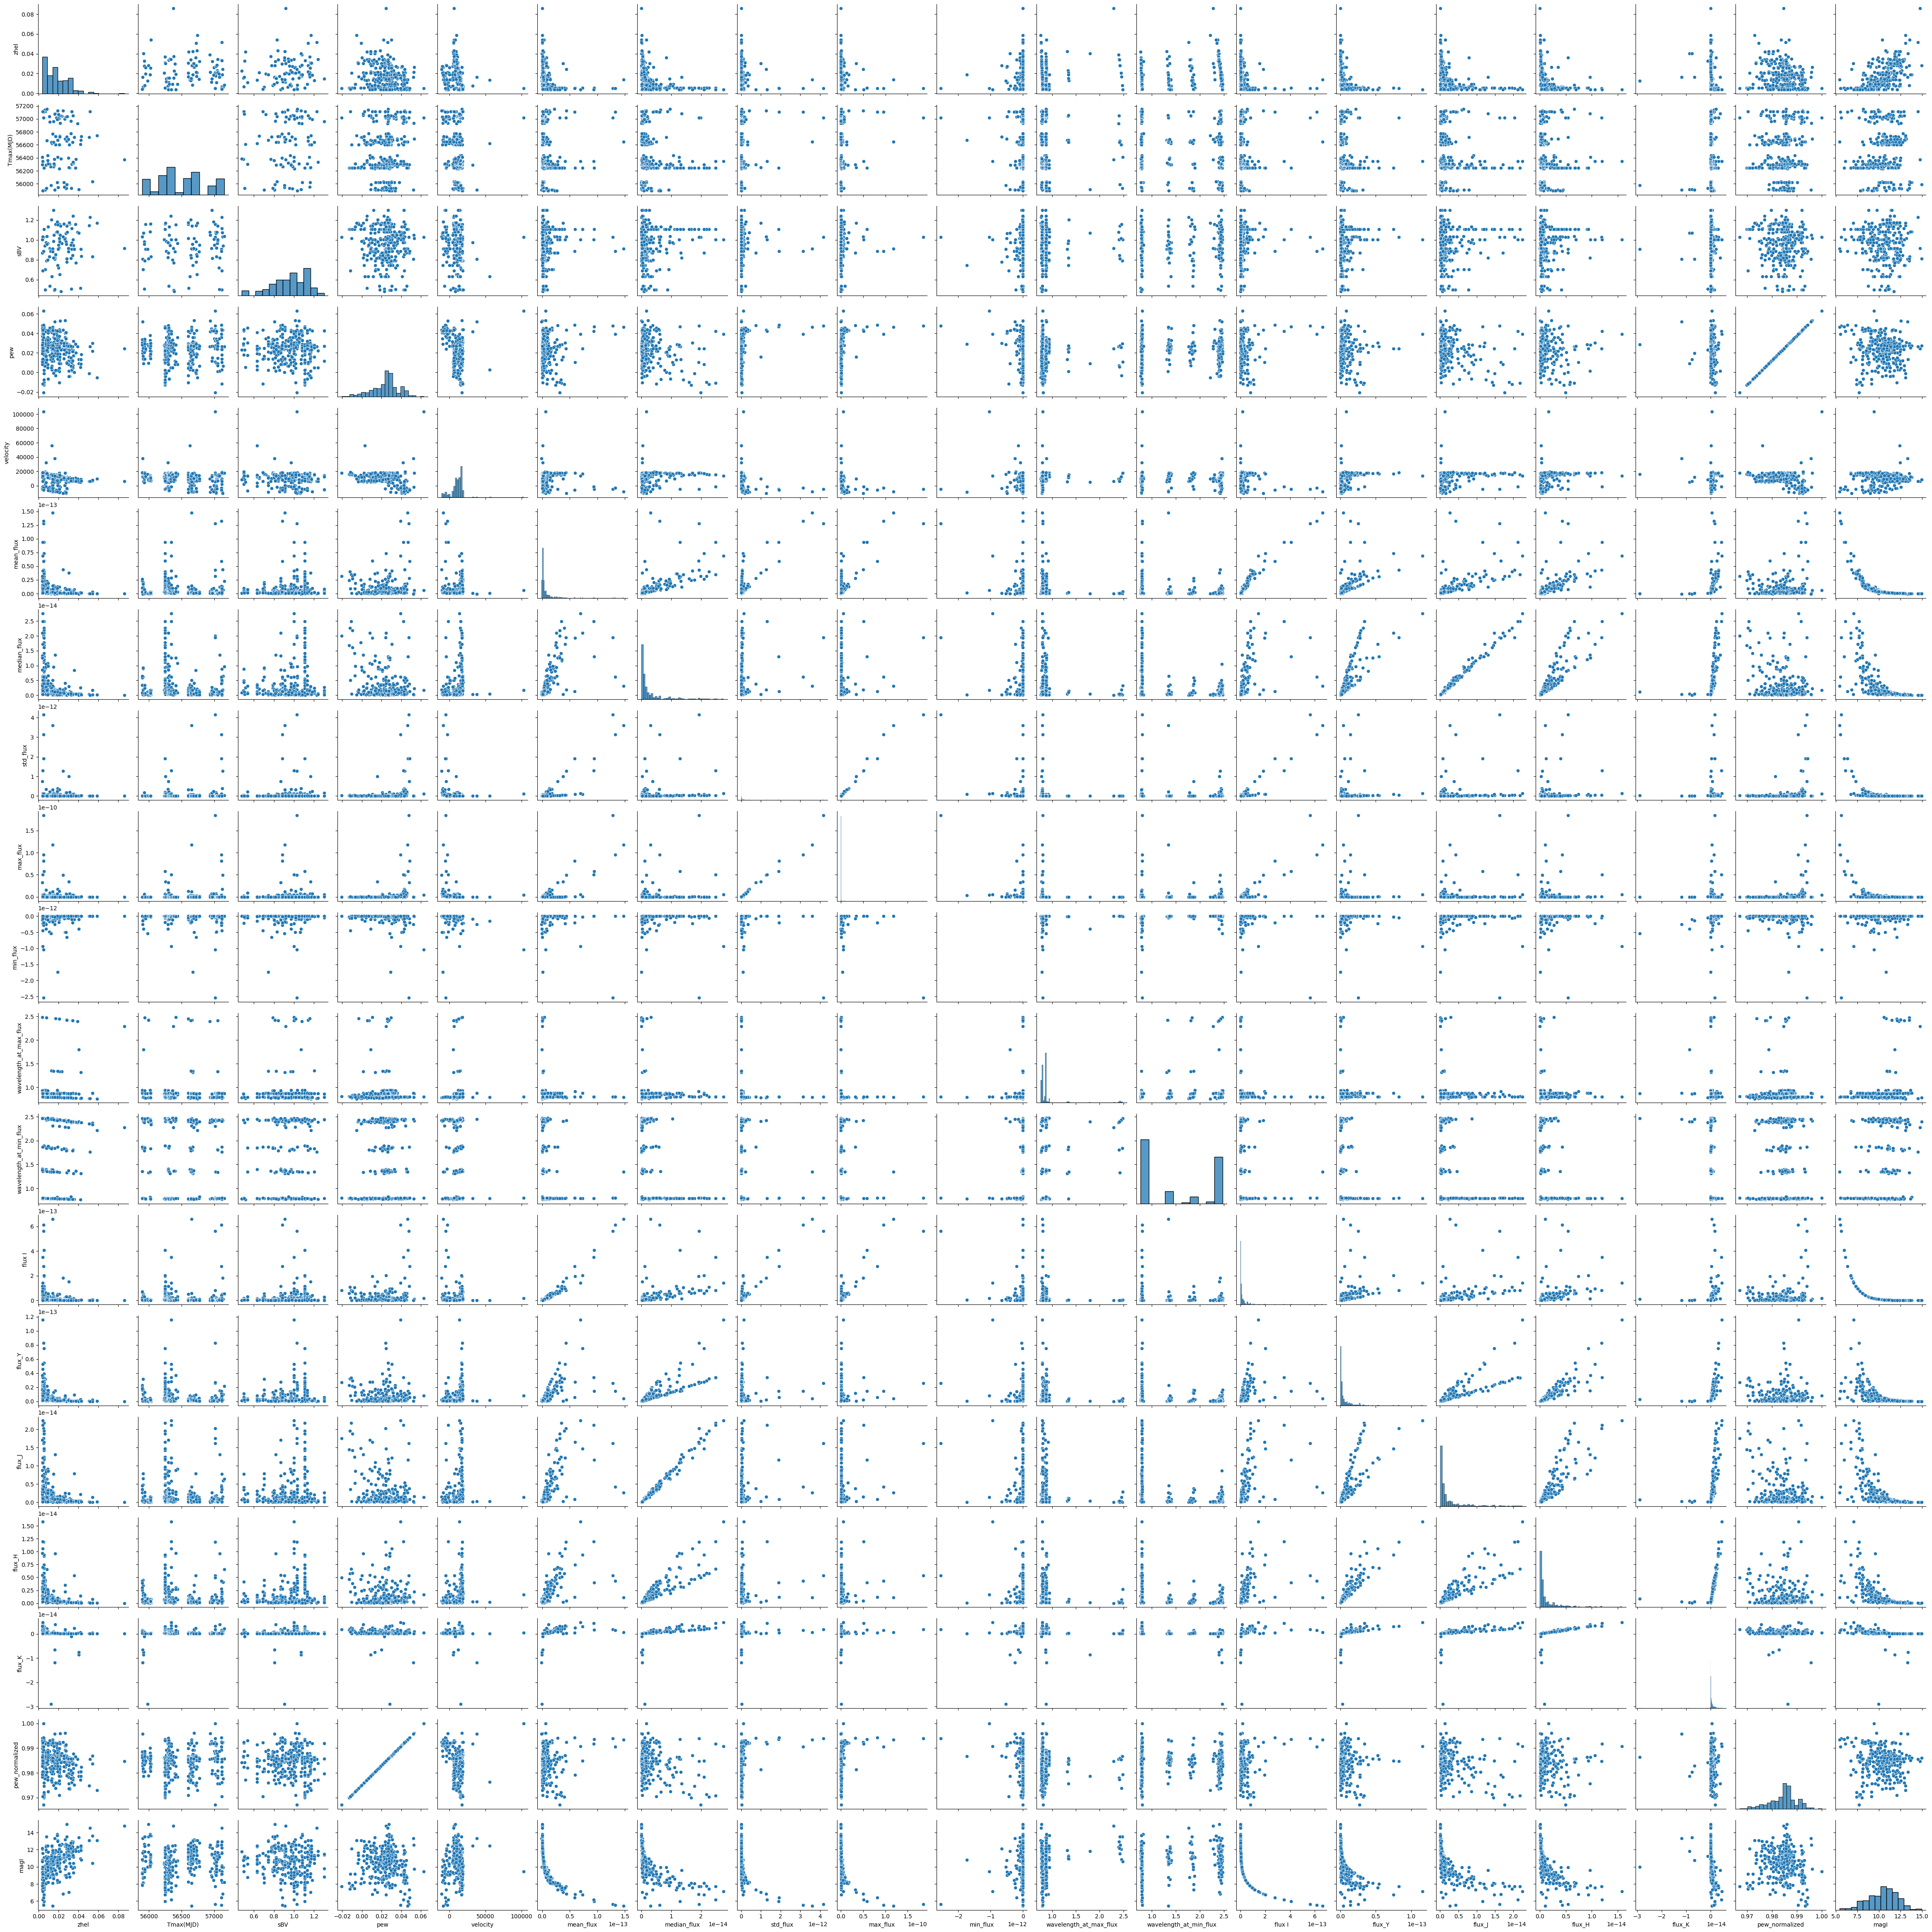

In [ ]:
features_to_plot = [col for col in filtered_pew_df.columns if col not in ['filename']]

sns.pairplot(filtered_pew_df[features_to_plot])
plt.show()


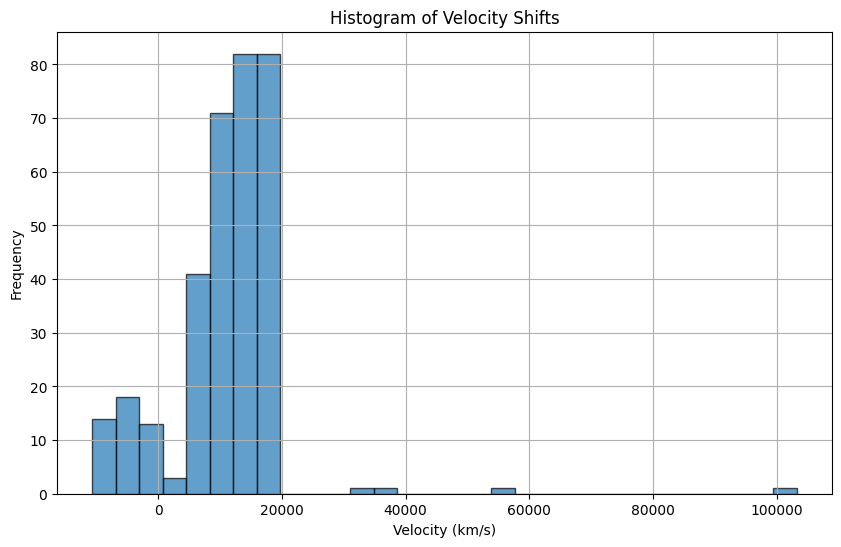

In [ ]:
if 'velocity' in filtered_pew_df.columns:
    # Plot the histogram of velocities
    plt.figure(figsize=(10, 6))
    plt.hist(filtered_pew_df['velocity'].dropna(), bins=30, edgecolor='black', alpha=0.7)
    plt.xlabel('Velocity (km/s)')
    plt.ylabel('Frequency')
    plt.title('Histogram of Velocity Shifts')
    plt.grid(True)
    plt.show()
else:
    print("No 'velocity' column found in features_df.")

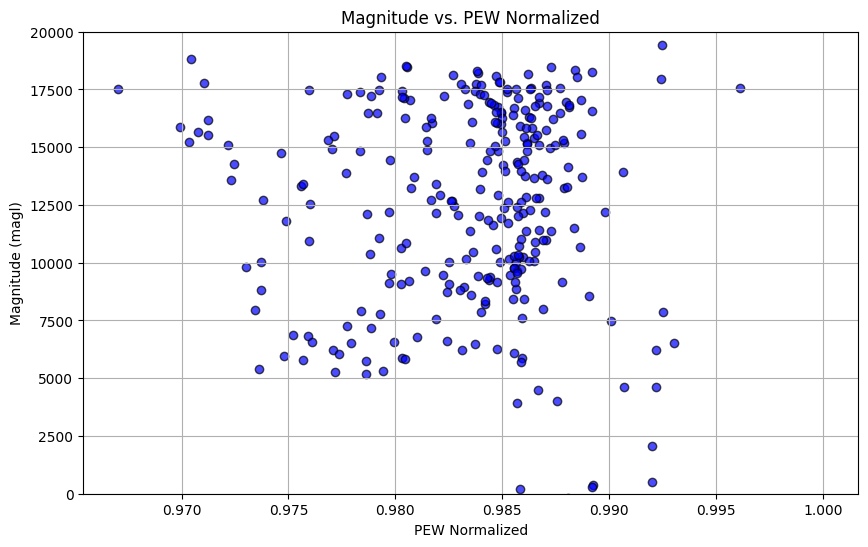

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(filtered_pew_df['pew_normalized'], filtered_pew_df['velocity'], color='blue', alpha=0.7, edgecolors='k')
plt.ylim(-1,20000)
plt.xlabel('PEW Normalized')
plt.ylabel('Magnitude (magl)')
plt.title('Magnitude vs. PEW Normalized')
plt.grid(True)
plt.show()

In [ ]:
spectral_data = filtered_pew_df[(filtered_pew_df['velocity'] > -1) & (features_copy['velocity'] < 20000)]

# Print the new DataFrame
print(spectral_data)

                    filename    zhel  Tmax(MJD)    sBV       pew  \
0     ASAS14ad_20140208_fire  0.0264   56692.70  1.013  0.018486   
1     ASAS14ad_20140215_fire  0.0264   56692.70  1.013  0.028867   
2     ASAS14ad_20140222_fire  0.0264   56692.70  1.013  0.053259   
3     ASAS14ad_20140227_fire  0.0264   56692.70  1.013  0.035828   
5     ASAS14ad_20140325_fire  0.0264   56692.70  1.013  0.030825   
..                       ...     ...        ...    ...       ...   
332    SN2015F_20150412_fire  0.0049   57106.85  0.884  0.035759   
334   CSP15aae_20150307_fire  0.0162   57076.02  0.505  0.034488   
336  SNhunt281_20150407_fire  0.0041   57112.67  0.692 -0.011863   
337  SNhunt281_20150412_fire  0.0041   57112.67  0.692  0.013651   
338  SNhunt281_20150601_fire  0.0041   57112.67  0.692  0.043354   

         velocity     mean_flux   median_flux      std_flux      max_flux  \
0     8727.325837  4.216527e-16  2.181891e-16  4.569898e-16  3.187331e-15   
1    10057.811210  3.772785e-

<ipython-input-15-2a2b9585a80e>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  spectral_data = filtered_pew_df[(filtered_pew_df['velocity'] > -1) & (features_copy['velocity'] < 20000)]


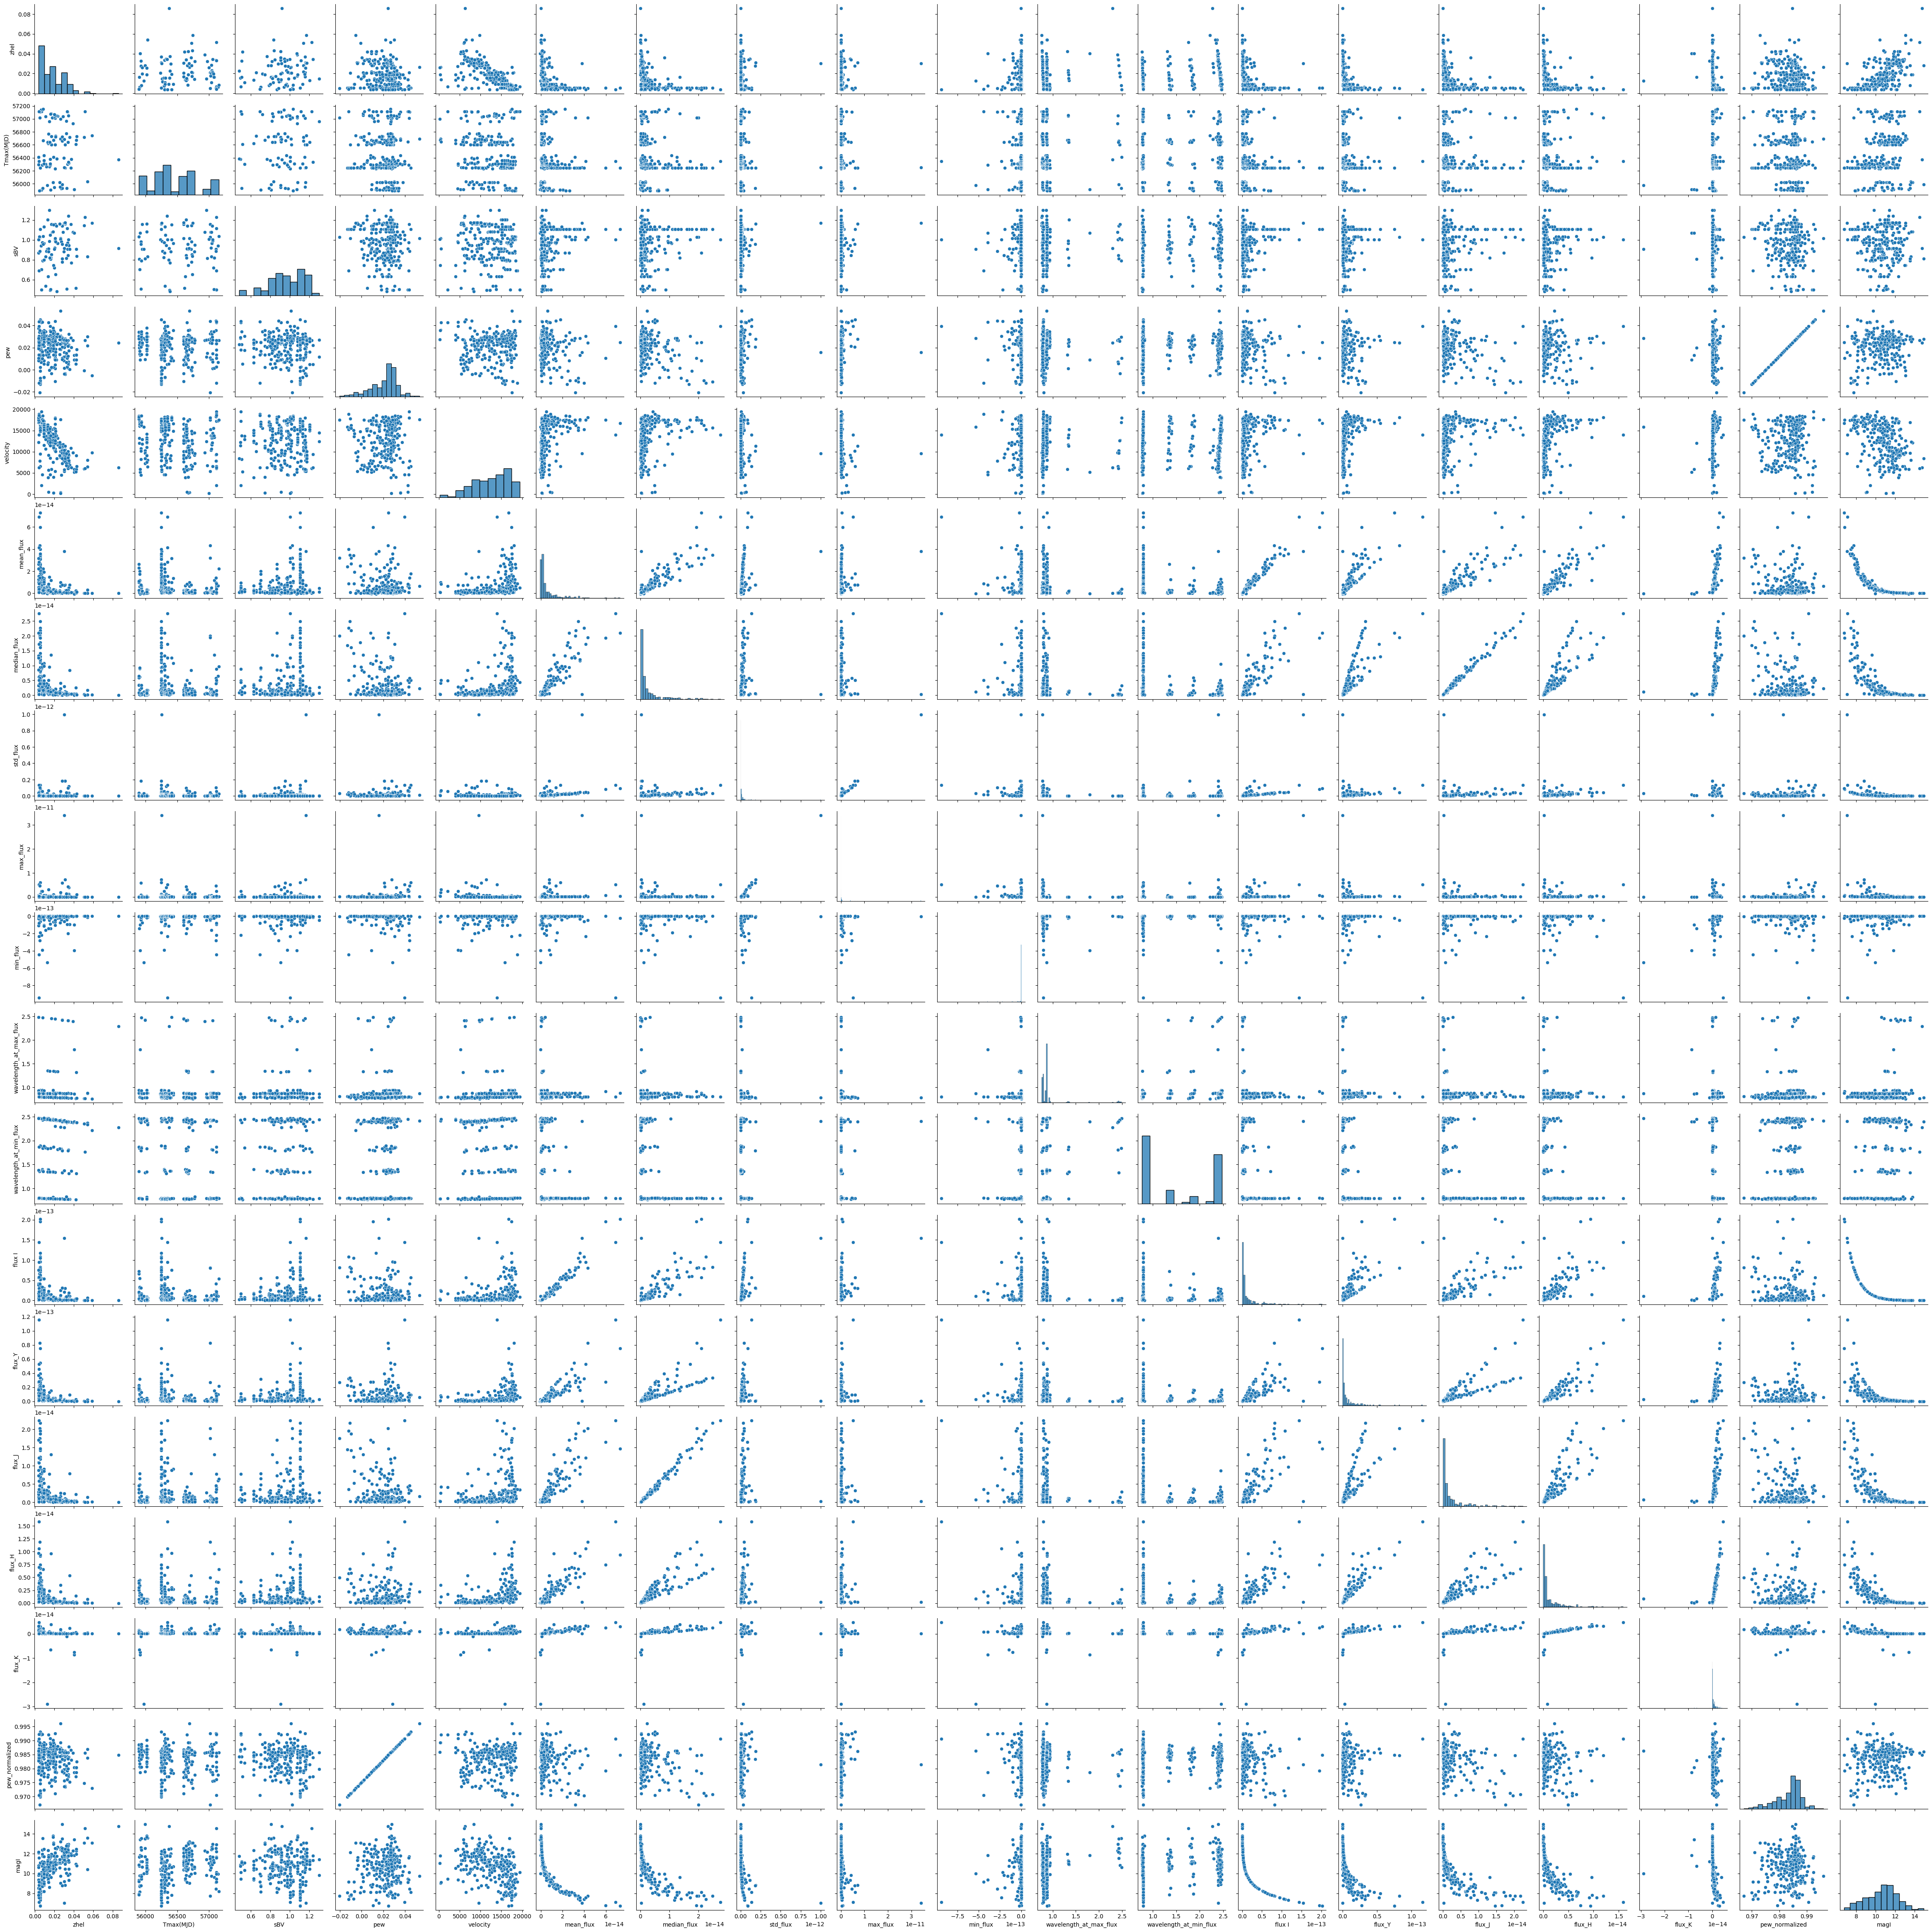

In [ ]:
features_to_plot = [col for col in spectral_data.columns if col not in ['filename']]

sns.pairplot(spectral_data[features_to_plot])
plt.show()

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler


selected_features = ['velocity','magI','pew_normalized','max_flux','wavelength_at_max_flux','zhel','flux_H','sBV','Tmax(MJD)']
selected_features2 = ['zhel','magK','sBV','wavelength_at_max_flux','Tmax(MJD)']
df_scaled = spectral_data[selected_features]



'''scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_selected)'''


'scaler = StandardScaler()\ndf_scaled = scaler.fit_transform(df_selected)'

In [ ]:

print("Initial missing values:\n", df_scaled2.isnull().sum())


selected_df = df_scaled2.dropna()

print("Missing values after removing rows:\n", selected_df.isnull().sum())


print(selected_df.head())

NameError: name 'df_scaled2' is not defined

In [ ]:

print("Initial missing values:\n", df_scaled.isnull().sum())


selected_df2 = df_scaled.dropna()

print("Missing values after removing rows:\n", selected_df2.isnull().sum())


print(selected_df2.head())

Initial missing values:
 velocity                  0
magI                      0
pew_normalized            0
max_flux                  0
wavelength_at_max_flux    0
zhel                      0
flux_H                    0
sBV                       0
Tmax(MJD)                 0
dtype: int64
Missing values after removing rows:
 velocity                  0
magI                      0
pew_normalized            0
max_flux                  0
wavelength_at_max_flux    0
zhel                      0
flux_H                    0
sBV                       0
Tmax(MJD)                 0
dtype: int64
       velocity       magI  pew_normalized      max_flux  \
0   8727.325837  12.401869        0.982403  3.187331e-15   
1  10057.811210  12.540197        0.986493  2.513188e-15   
2  17561.677628   9.737769        0.996104  4.155343e-14   
3    377.110031   9.006128        0.989236  1.786641e-12   
5  11363.043229  13.189636        0.987264  1.049815e-15   

   wavelength_at_max_flux    zhel        flux_H

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(selected_df[['Tmax(MJD)','sBV']])
new_df = pd.DataFrame(scaled_data, columns=['Tmax', 'sBV'])
print(new_df.head())

       Tmax       sBV
0  0.635319  0.649573
1  0.635319  0.649573
2  0.635319  0.649573
3  0.635319  0.649573
4  0.635319  0.649573


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

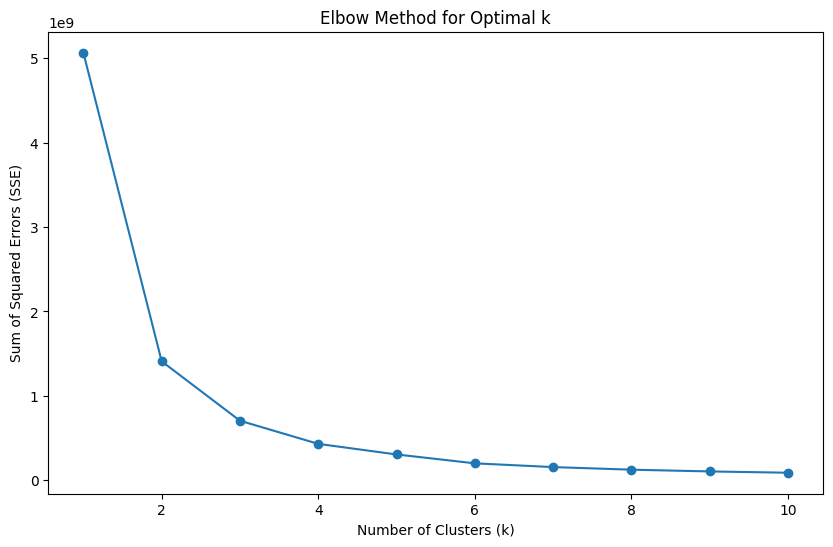

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

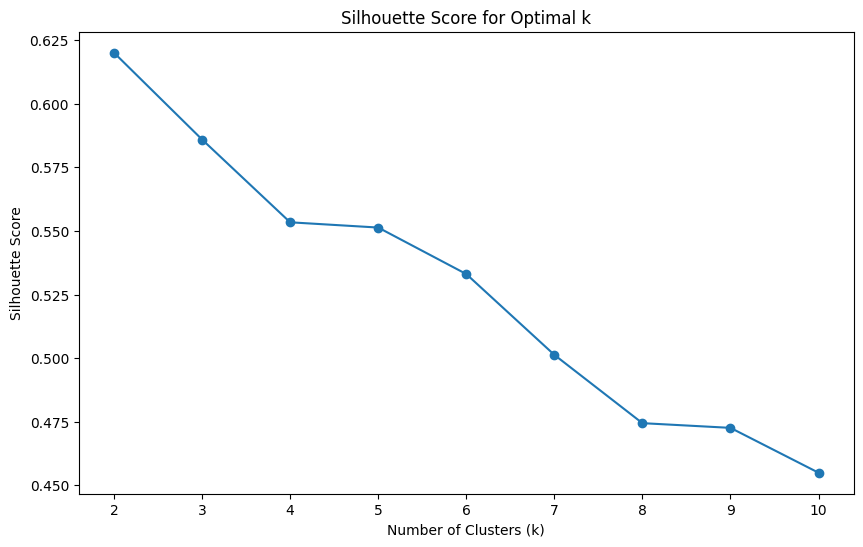

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Elbow Method
sse = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(selected_df2)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, sse, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.title('Elbow Method for Optimal k')
plt.show()

# Silhouette Score
silhouette_scores = []
for k in k_range[1:]:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(selected_df2)
    silhouette_scores.append(silhouette_score(selected_df2, labels))

plt.figure(figsize=(10, 6))
plt.plot(k_range[1:], silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k')
plt.show()


In [ ]:

optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
selected_df2['Cluster'] = kmeans.fit_predict(selected_df2)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [ ]:
print(sum((selected_df2['Cluster'] == 1).sum()))

TypeError: 'numpy.int64' object is not iterable

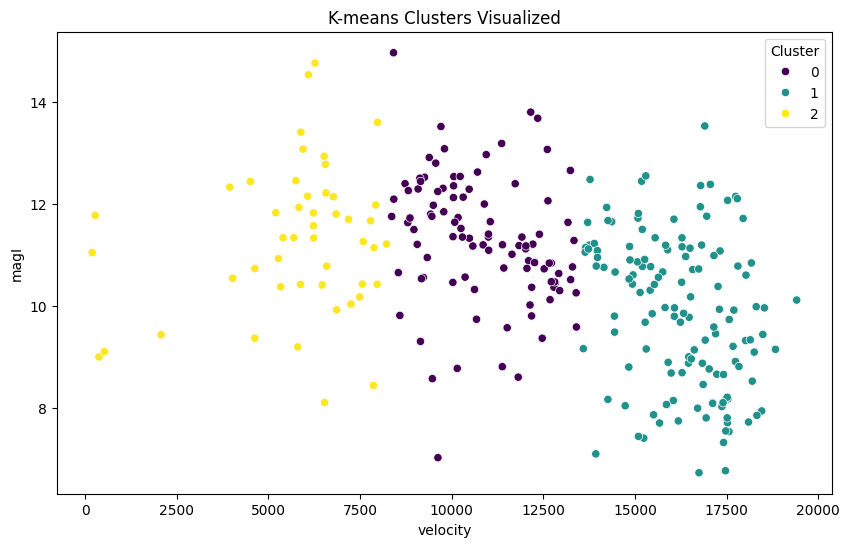

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize the clusters in a pairplot
'''sns.pairplot(df_selected, hue='Cluster', diag_kind='kde', palette='viridis')
plt.show()

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_components = pca.fit_transform(selected_df2)
df_pca = pd.DataFrame(data=pca_components, columns=['PC1', 'PC2'])
df_pca['Cluster'] = selected_df2['Cluster']'''


# Create the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='velocity', y='magI', hue='Cluster', data=selected_df2, palette='viridis')

# Set the title of the plot
plt.title('K-means Clusters Visualized')



# Show the plot
plt.show()


USING magK

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

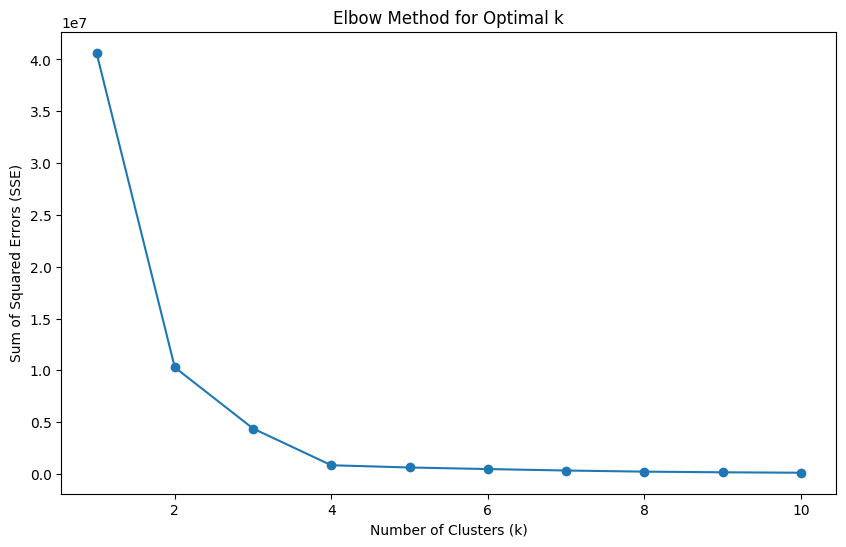

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

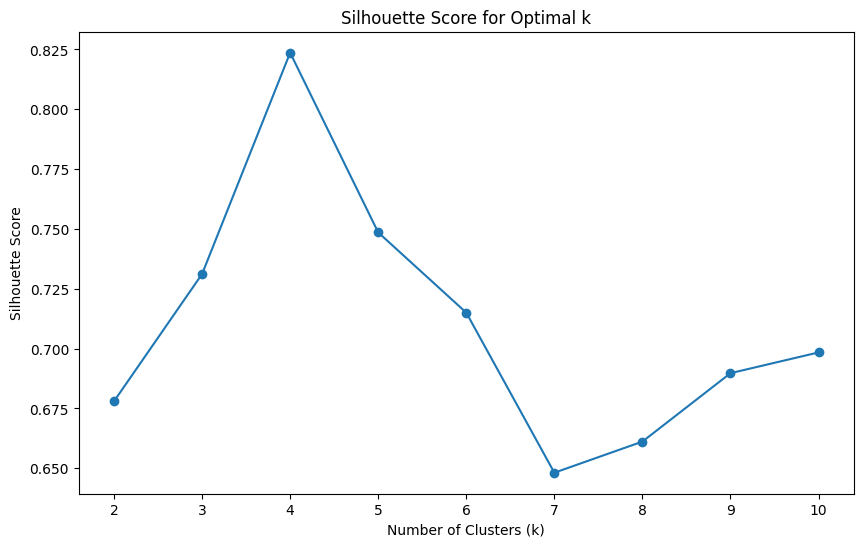

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Elbow Method
sse = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(selected_df)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, sse, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.title('Elbow Method for Optimal k')
plt.show()

# Silhouette Score
silhouette_scores = []
for k in k_range[1:]:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(selected_df)
    silhouette_scores.append(silhouette_score(selected_df, labels))

plt.figure(figsize=(10, 6))
plt.plot(k_range[1:], silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k')
plt.show()


In [ ]:
# Assuming the optimal number of clusters is 3
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
selected_df['Cluster'] = kmeans.fit_predict(selected_df)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
<ipython-input-12-cc2c8ece4177>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df['Cluster'] = kmeans.fit_predict(selected_df)


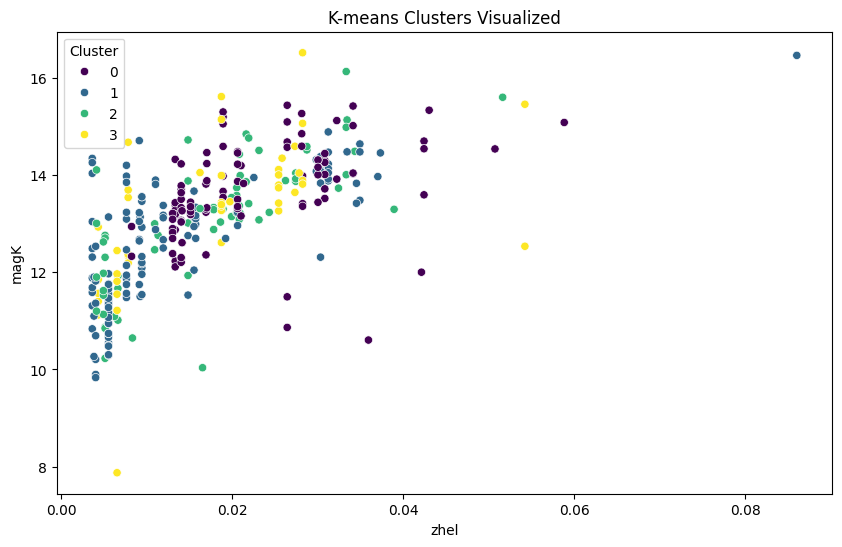

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

'''sns.pairplot(df_selected, hue='Cluster', diag_kind='kde', palette='viridis')
plt.show()

# Visualize clusters in 2D using PCA for dimensionality reduction
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_components = pca.fit_transform(df_scaled)
df_pca = pd.DataFrame(data=pca_components, columns=['PC1', 'PC2'])
df_pca['Cluster'] = df_selected['Cluster']'''

plt.figure(figsize=(10, 6))
sns.scatterplot(x='zhel', y='magK', hue='Cluster', data=selected_df, palette='viridis')
plt.title('K-means Clusters Visualized')


plt.show()


<ipython-input-35-61f8f0de8271>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spectral_data['cluster'] = gmm.predict(X_scaled)


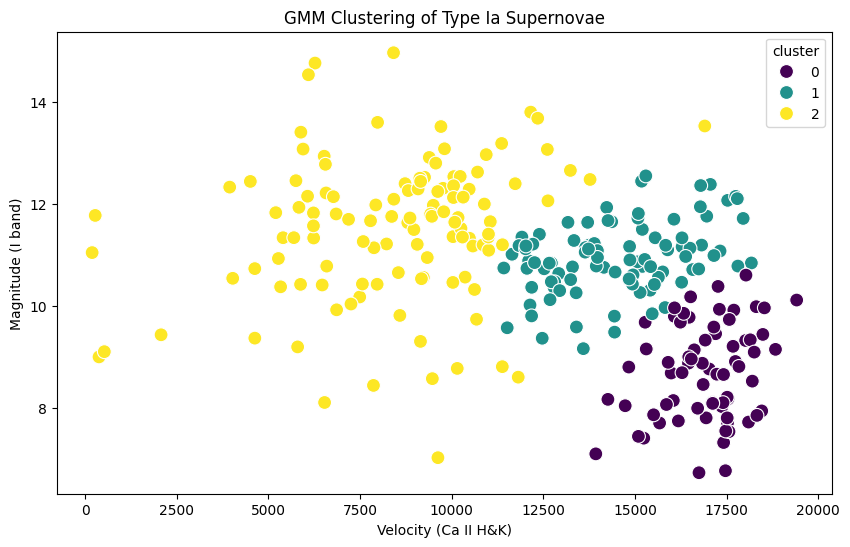

In [ ]:
import pandas as pd
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt


# Extract relevant features for clustering
X = spectral_data[['velocity', 'magI']]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit Gaussian Mixture Model with an appropriate number of clusters
gmm = GaussianMixture(n_components=3, random_state=42)
gmm.fit(X_scaled)

# Predict cluster labels
spectral_data['cluster'] = gmm.predict(X_scaled)

# Visualize the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='velocity', y='magI', hue='cluster', data=spectral_data, palette='viridis', s=100)
plt.title('GMM Clustering of Type Ia Supernovae')
plt.xlabel('Velocity (Ca II H&K)')
plt.ylabel('Magnitude (I band)')
plt.show()


<ipython-input-37-14b6c54b6bb5>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spectral_data['cluster'] = gmm.predict(X_scaled)


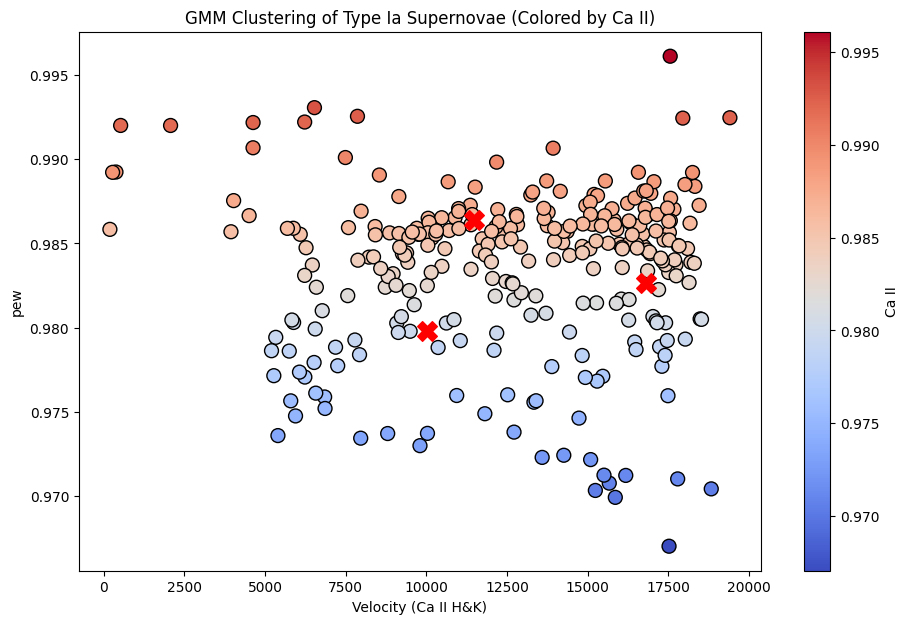

In [ ]:
import pandas as pd
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your actual dataset is already loaded into a DataFrame named 'spectral_data'
# Ensure 'velocity', 'magI', and 'sBV' are in the DataFrame

# Extract relevant features for clustering
X = spectral_data[['velocity','pew_normalized','magI']]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit Gaussian Mixture Model with an appropriate number of clusters
# Here n_components is set to 3, adjust it based on your specific needs
gmm = GaussianMixture(n_components=3, random_state=42)
gmm.fit(X_scaled)

# Predict cluster labels
spectral_data['cluster'] = gmm.predict(X_scaled)

# Visualize the clusters and color the points by the sBV values
plt.figure(figsize=(11, 7))
scatter = plt.scatter(
    x=spectral_data['velocity'],
    y=spectral_data['pew_normalized'],
    c=spectral_data['pew_normalized'],  # Use sBV for color
    cmap='coolwarm',  # Color map for sBV
    s=100,  # Size of points
    edgecolor='k',  # Add black edges to points

)
plt.title('GMM Clustering of Type Ia Supernovae (Colored by Ca II)')
plt.xlabel('Velocity (Ca II H&K)')
plt.ylabel('pew')
plt.colorbar(scatter, label='Ca II')  # Add color bar to show sBV values

# Overlay cluster centers for better visualization (optional)
cluster_centers = scaler.inverse_transform(gmm.means_)
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], s=200, c='red', marker='X')

plt.show()

# Optionally, save the cluster labels to a CSV
# spectral_data.to_csv('spectral_data_with_clusters.csv', index=False)
